In [8]:
%matplotlib notebook
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
from torch.utils.data import DataLoader
import torchvision as tv
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import vocData as voc
import vocModel
from vocModel.utils import cal_iou
import time

import vocModel.nntools as nt

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


In [10]:
dataset_root_dir = "/datasets/ee285f-public/PascalVOC2012/"
lr = 1e-3
batch_size = 8

In [11]:
def voc_data_loader():
    dataset = voc.VOCDetection(dataset_root_dir,  image_set = 'trainval')
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    validation_split = 0.1
    test_split = 0.1
    val_split = int(np.floor(validation_split * dataset_size))
    test_split = int(np.floor(test_split * dataset_size))

    np.random.shuffle(indices)

    train_indices, val_indices, test_indices = indices[val_split+test_split:],\
    indices[:val_split], indices[val_split:val_split+test_split]

    print (len(train_indices) + len(val_indices) + len(test_indices))
    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    test_sampler =  SubsetRandomSampler(test_indices)
    # Define data loaders
    print (batch_size)
    train_loader = td.DataLoader(dataset, batch_size=batch_size, \
                                 sampler=train_sampler,\
                                 drop_last=True, pin_memory=True)

    val_loader = td.DataLoader(dataset, batch_size=batch_size,\
                               sampler=valid_sampler, \
                               drop_last=True, pin_memory=True)

    test_loader = td.DataLoader(dataset, batch_size=1,\
                               sampler=test_sampler, \
                               drop_last=False, pin_memory=False)

    return train_loader, val_loader, test_loader


In [12]:
train_loader, val_loader, test_loader = voc_data_loader()
print ("Dataset is divided into train :{}, val : {}, test :{} ".format(len(train_loader), len(val_loader), len(test_loader)))


11540
8
Dataset is divided into train :1154, val : 144, test :1154 


In [13]:
# net = vocModel.YoloNet(7, 2, 20, 5,0.5)
net = vocModel.YoloNet_res(7, 2, 20, 5,0.5)
net = net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay = 5*1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,60], gamma=0.1)
stats_manager = vocModel.DetectionStatsManager()
exp1 = nt.Experiment(net, train_loader, val_loader, optimizer, stats_manager,batch_size=batch_size,
                     output_dir="data/resnet_3", perform_validation_during_training=True)

In [14]:
class_dict = {'person' :0, 'bird' : 1, 'cat' : 2, 'cow': 3, 'dog': 4, 'horse' : 5, 'sheep' : 6,
                  'aeroplane' :7, 'bicycle' :8, 'boat' :9, 'bus':10, 'car':11, 'motorbike' :12, 'train':13,
                  'bottle' :14, 'chair':15, 'diningtable':16, 'pottedplant':17, 'sofa': 18, 'tvmonitor':19}
class_list = list(class_dict)

color_list = ['b', 'g', 'c', 'm', 'y', 'k', 'w']

In [41]:
def image_transform(image, ax=plt):
    normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                 std=[1/0.229, 1/0.224, 1/0.225])    
    image = np.array(normalize(image).numpy())
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    return image


def plot_single_image(output_bboxes, output_class_idx, gt_bboxes, gt_labels, axs) : 
    for i in range(gt_bboxes.size()[0]):
        xmin, ymin, xmax, ymax = gt_bboxes[i][0], gt_bboxes[i][1], gt_bboxes[i][2], gt_bboxes[i][3]
        print ("GT",gt_bboxes[i,:].to('cpu').numpy(), class_list[gt_labels[i]])
        rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=4,edgecolor='r',facecolor='none')
        axs.add_patch(rect)



    for i in range(output_bboxes.size()[0]):
        xmin, ymin, xmax, ymax = output_bboxes[i,:4]
        t = output_class_idx[i]
        print (output_bboxes[i,:].to('cpu').numpy(), class_list[t])
        color = color_list[t % len(color_list)]
        rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=2,edgecolor=color,facecolor='none')
        axs.add_patch(rect)

    
def from_target_to_bndboxes(target):

    target_bboxes =  target.view(-1, 30)
    object_mask = target_bboxes[:,4] >0    
    
    wh= torch.pow(target_bboxes[:,[2,3]], 2)
    ij = torch.from_numpy(np.array([ (i%C, i//C) for i in range(C*C)])).to(device).float()
    xy_center = (target_bboxes[:,[0,1]] + ij)* cell_size
    xy_min = xy_center - wh/2
    xy_min = torch.max(xy_min, torch.zeros_like(xy_min)) * 448.0
    xy_max = xy_center + wh/2
    xy_max = torch.min(xy_max, torch.ones_like(xy_min)) * 448.0

    gt_bboxes =torch.cat((xy_min,  xy_max), dim = 1)

    gt_bboxes = gt_bboxes[object_mask].view(-1,4)
    gt_labels = torch.argmax(target_bboxes[:,10:], dim = 1)[object_mask].view(-1,1)

    return gt_bboxes, gt_labels

    
    
def from_prediction_to_bndboxes(output, conf_threshold):
    
    output_bboxes =  output.view(-1, 30)[:,:10]
    maxi = torch.eq(output_bboxes[:,[4,9]], torch.max(output_bboxes[:,[4,9]], dim =1)[0].unsqueeze(1)).view(-1)
    output_bboxes = output_bboxes.contiguous().view(-1,5)[maxi]
    output_class_prob, output_labels = torch.max(output.view(-1, 30)[:,10:], dim = 1)
    output_bboxes[:,4] *= output_class_prob

    # calculate bndboxes to xmin, ymin, xmax, ymax
    wh= torch.pow(output_bboxes[:,[2,3]], 2)
    ij = torch.from_numpy(np.array([ (i%C, i//C) for i in range(C*C)])).to(device).float()
    xy_center = (output_bboxes[:,[0,1]] + ij)* cell_size
    xy_min = xy_center - wh/2
    xy_min = torch.max(xy_min, torch.zeros_like(xy_min)) * 448.0
    xy_max = xy_center + wh/2
    xy_max = torch.min(xy_max, torch.ones_like(xy_min)) * 448.0
    output_bboxes[:,:4] = torch.cat((xy_min,  xy_max), dim = 1)

    # Choose high confidence bnd boxes
    conf_selected =output_bboxes[:,4] > conf_threshold
    output_bboxes = output_bboxes[conf_selected]
    output_labels = output_labels[conf_selected]
    
    return output_bboxes, output_labels.view(-1,1)

<IPython.core.display.Javascript object>


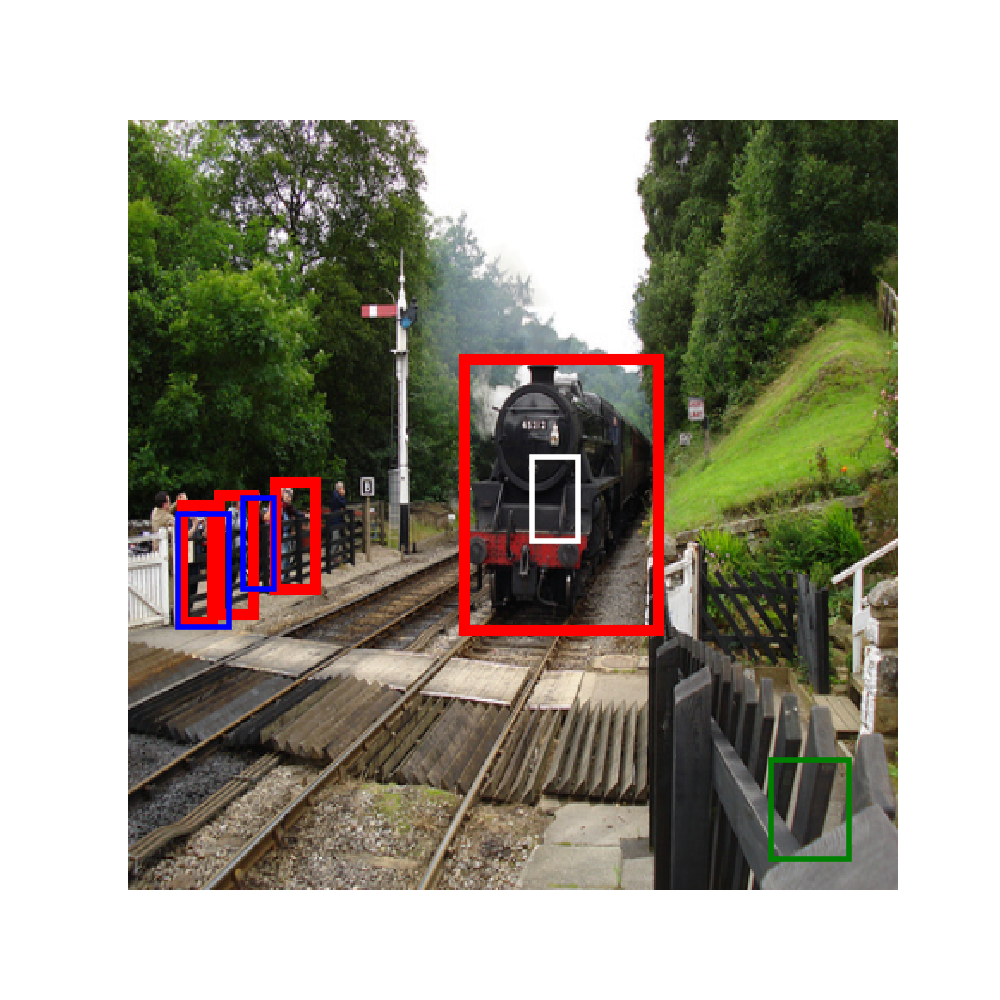

GT [ 52.864    217.42932   72.576004 286.72    ] person
GT [ 85.119995 210.26134  108.416    272.384   ] person
GT [195.328   138.58131 308.22403 296.27734] train
GT [ 31.36     223.40268   48.384003 291.49866 ] person
[ 66.955986  219.6964     84.4948    272.4594      0.7553341] person
[234.98282   195.62665   261.60547   244.38354     0.8988306] train
[ 29.165277  228.86356    58.482338  294.6391      0.4513086] person
[3.7399088e+02 3.7159543e+02 4.1933020e+02 4.2945352e+02 3.2947341e-01] chair


In [42]:
test_iter = iter(test_loader)
net.eval()
with torch.no_grad():
    img, target= next(test_iter)
    img, target= img.to(device), target.to(device)
    C = 7
    B = 2
    w = 448
    h = 448
    cell_size = 1./C
    conf_threshold = 0.2
    ious_threshold = 0.3

    output = net.forward(img)
    output = output[0]
    target = target[0]

    # undo normailization
    img_mod = image_transform(img[0].to('cpu'))

    #gt variables
    gt_bboxes, gt_labels = from_target_to_bndboxes(target)
    # output to bndboxes
    output_bboxes, output_labels = from_prediction_to_bndboxes(output, conf_threshold)

    fig, axs = plt.subplots(ncols=1, figsize=(5, 5))
    plot_single_image(output_bboxes, output_labels, gt_bboxes, gt_labels, axs)
    axs.axis('off')
    axs.imshow(img_mod)
    



In [47]:
s = time.time()
predictions = []
for i in range(len(class_dict)):
    predictions.append([])
print (predictions)
gt_class_count = torch.zeros(len(class_dict)).view(1,-1).to(device)
print (gt_class_count)
test_iter = iter(test_loader)
print (len(test_loader))
net.eval()
with torch.no_grad():
#     for img, target in test_loader:
    for t in range(1):
        img, target= next(test_iter)
        img, target= img.to(device), target.to(device)
        C = 7
        B = 2
        w = 448
        h = 448
        cell_size = 1./C
        conf_threshold = 0.2
        ious_threshold = 0.3

        output = net.forward(img)
        output = output[0]
        target = target[0]

        # undo normailization
        img_mod = image_transform(img[0].to('cpu'))

        #gt variables
        gt_bboxes, gt_labels = from_target_to_bndboxes(target)
        # output to bndboxes
        output_bboxes, output_labels = from_prediction_to_bndboxes(output, conf_threshold)

        
#         #plot image
#         fig, axs = plt.subplots(ncols=1, figsize=(5, 5))
#         plot_single_image(output_bboxes, output_labels, gt_bboxes, gt_labels, axs)
#         axs.axis('off')
#         axs.imshow(img_mod)
    
        # Count number of GTs for each Class
        temp =torch.zeros((gt_labels.size()[0], len(class_dict))).to(device)
        temp[torch.arange(gt_labels.size()[0]),gt_labels] += 1
        temp = torch.sum(temp, dim = 0)
        gt_class_count += temp
        
        

            
print ("testing time : {}".format(time.time()-s))

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
1154
torch.Size([2, 4]) torch.Size([2, 1])
torch.Size([3, 5]) torch.Size([3, 1])
0
torch.Size([0, 0])
1
torch.Size([0, 0])
2
torch.Size([2, 3])
3
torch.Size([0, 0])
4
torch.Size([0, 0])
5
torch.Size([0, 0])
6
torch.Size([0, 0])
7
torch.Size([0, 0])
8
torch.Size([0, 0])
9
torch.Size([0, 0])
10
torch.Size([0, 0])
11
torch.Size([0, 0])
12
torch.Size([0, 0])
13
torch.Size([0, 0])
14
torch.Size([0, 0])
15
torch.Size([0, 0])
16
torch.Size([0, 0])
17
torch.Size([0, 0])
18
torch.Size([0, 0])
19
torch.Size([0, 0])
testing time : 0.3469555377960205


In [61]:
#Classifying TP of FP
for class_label in range(len(class_dict)):

    print (class_label)
    gt_mask = (gt_labels.view(-1) == class_label  )
    output_mask = (output_labels.view(-1) == class_label)
    gt_bboxes_class = gt_bboxes[gt_mask]
    output_bboxes_class = output_bboxes[output_mask]

    ious = cal_iou(gt_bboxes_class, output_bboxes_class[:,:4])
    print (ious.size())

    if ious.size()[0] ==0 :
        for i in range(ious.size()[1]):
            predictions[class_label].append((output_bboxes_class[i,4], 0))                

    else :
        
        idxes = [(i,output_bboxes_class[i,4].item()) for i in range(ious.size()[1])]
        
        idxes = sorted(idxes, key = lambda x : x[1], reverse= True)
        
        left_idxes = list(range(ious.size()[0]))
        for i in range(ious.size()[1]):
            
            
#             print (torch.argmax(ious[:,i]))
                  
            if len(left_idxes)==0:
                break;
                
                
            
            
        

0
torch.Size([0, 0])
1
torch.Size([0, 0])
2
torch.Size([2, 3])
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
3
torch.Size([0, 0])
4
torch.Size([0, 0])
5
torch.Size([0, 0])
6
torch.Size([0, 0])
7
torch.Size([0, 0])
8
torch.Size([0, 0])
9
torch.Size([0, 0])
10
torch.Size([0, 0])
11
torch.Size([0, 0])
12
torch.Size([0, 0])
13
torch.Size([0, 0])
14
torch.Size([0, 0])
15
torch.Size([0, 0])
16
torch.Size([0, 0])
17
torch.Size([0, 0])
18
torch.Size([0, 0])
19
torch.Size([0, 0])


In [53]:
a = list(range(10))

In [55]:
a.pop(4)
print (a)

[0, 1, 2, 3, 5, 6, 8, 9]


# Calculating mAP

In [ ]:
i=0
predicion_class = predictions[i]

predicion_class = sorted(predictions[i], key=lambda pred: pred[0], reverse = True)

precisions =[]
recalls = []
TPs = 0 
GT_TPs = gt_class_count[0,0]
print( gt_class_count[0,0])
for idx, (confidence, TP) in enumerate(predicion_class):
    
    TPs += TP
    
    curr_precision = TPs*1.0/(idx+1)
    curr_recall = TPs*1.0/GT_TPs

    precisions.append(curr_precision)
    recalls.append(curr_recall)


In [ ]:
print (precisions[:10])
print (recalls[:10])

In [ ]:
fig, axes = plt.subplots(ncols=1, figsize=(5, 5))

axes.clear()
axes.plot(precisions, recalls,
             label="people")
axes.set_xlabel("recall")
axes.set_ylabel("precision")
plt.tight_layout()
fig.canvas.draw()